In [1]:
import re
import os
import csv
import shutil
from shutil import copyfile


import nltk
import re
import numpy as np
import pandas as pd
import spacy
from pprint import pprint
import gensim
import logging
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
stop_words = stopwords.words('english')
nltk.download('stopwords')
# Enable logging for gensim - optional
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
nlp = spacy.load('en', disable=['parser', 'ner'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/savanpatel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/anaconda2/envs/Revision2/lib/python3.6/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
/anaconda2/envs/Revision2/lib/python3.6/site-packages/msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)


In [4]:
'''
create 2 folder before proceeding under the Data Processing directory, one with the username of the seed and the other with 
"tweets" under the username folder
'''

'\ncreate 2 folder before proceeding under the Data Processing directory, one with the username of the seed and the other with \n"tweets" under the username folder\n'

In [6]:
# moving tweet.csv to a single folder and renaming them
for root, dirs, files in os.walk("/Users/savanpatel/Desktop/sfsu/research/spamDetection/SDUTDPRev3/DataCollection/Graph-Users-tweets/"):
    for file in files:
        if file.endswith(".csv"):
            dst = "/Users/savanpatel/Desktop/sfsu/research/spamDetection/SDUTDPRev3/DataProcessing/Daddythompson2/"+file
            copyfile(os.path.join(root, file), dst)

In [7]:
def delete_file(file_name):
    os.remove(file_name)
    

def tweet_cleaning(file_list):
    # get rid of the URL's in the tweets
    # get rid of user mentions eg @username
    for file in file_list:
        try:
            with open(file) as csv_file:
                csv_reader = csv.DictReader(csv_file, delimiter=',')
                line_count = 0
                clean_content = {}
                for row in csv_reader:
                    if line_count == 0:
                        clean_content[str(line_count)] = {}
                        clean_content[str(line_count)]["tweet"] = "tweet"
                        clean_content[str(line_count)]["retweets"] = "retweets"
                        clean_content[str(line_count)]["id"] = "id"
                        line_count = line_count + 1
                        pass
                    else:
                        clean_content[str(line_count)] = {}
                        url_free_tweet = remove_url(row["tweet"])
                        hashtag_free_tweet = remove_hashtags(url_free_tweet)
                        clean_content[str(line_count)]["tweet"] = remove_user_mentions(hashtag_free_tweet)
                        clean_content[str(line_count)]["retweets"] = row["retweets"]
                        clean_content[str(line_count)]["id"] = row["id"]
                        line_count = line_count + 1

            # save the url free content to a file
            with open("tweets/clean_"+file, mode='w') as csv_writer:
                url_free_writer = csv.writer(csv_writer, delimiter=',')
                for row in clean_content:
                    url_free_writer.writerow([clean_content[row]["tweet"], clean_content[row]["retweets"], clean_content[row]["id"] ])

            # delete original file
            # delete_file(file)
        except:
            # delete original file
            # delete_file("tweets/"+file)
            print("Exception caused")

In [8]:
def remove_url(line):
    url_free_line_1 = re.sub(r'http\S+', '', line)
    url_free_line_2 = re.sub(r'[a-z]*.twitter.com\/[a-zA-Z0-9]+', '', url_free_line_1)
    return url_free_line_2

In [9]:
def remove_user_mentions(line):
    user_mention_free = re.sub(r'(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)', '', line)
    return user_mention_free


def remove_hashtags(line):
    hashtag_free_line = re.sub(r'\B(\#[a-zA-Z0-9]+\b)(?!;)', '', line)
    return hashtag_free_line


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [11]:
os.chdir("/Users/savanpatel/Desktop/sfsu/research/spamDetection/SDUTDPRev3/DataProcessing/Daddythompson2")
# clean all the tweets in all the files
sub_files = [f.name for f in os.scandir(".") if f.is_file()]
print(len(sub_files))

1307


In [12]:
tweet_cleaning(sub_files)

In [13]:
cleaned_sub_files = [f.name for f in os.scandir("tweets/.") if f.is_file()]
data = {}

In [14]:
for item in cleaned_sub_files:
    try:
        temp = pd.read_csv("tweets/"+item)
        data[item] = temp.tweet
    except:
        pass
data_words = list(sent_to_words(data.values()))
print(data_words[:1])

[['teamwork', 'am', 'your', 'negan', 'negan', 'right', 'hand', 'gore', 'viol', 'bbl', 'good', 'morning', 'bro', 'coffee', 'and', 'cookie', 'from', 'car', '咳て夜中はほとんと寝れないー', 'おはようこさいます', 'he', 'needed', 'rest', 'he', 'got', 'out', 'of', 'the', 'car', 'and', 'the', 'key', 'was', 'lying', 'on', 'the', 'passenger', 'seat', 'he', 'the', 'street', 'was', 'like', 'car', 'cemetery', 'some', 'were', 'my', 'muse', 'is', 'so', 'low', 'at', 'the', 'moment', 'could', 'thr', 'dear', 'rpers', 'there', 'is', 'one', 'rule', 'have', 'and', 'it', 'so', 'never', 'apologize', 'for', 'being', 'away', 'and', 'if', 'yo', 'expect', 'the', 'same', 'from', 'you', 'let', 'just', 'have', 'for', 'while', 'thank', 'you', 'my', 'sexy', 'cookie', 'monster', 'cookie', 'for', 'this', 'sweet', 'and', 'hot', 'cookie', 'babe', 'flirty', 'eyes', 'all', 'for', 'you', 'alone', 'you', 'know', 'what', 'looking', 'at', 'my', 'notifications', 'like', 'ff_specialツ', 'my', 'special', 'for', 'my', 'love', 'can', 'believe', 'it', 'wha

In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

/anaconda2/envs/Revision2/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [16]:
trigram_mod = gensim.models.phrases.Phraser(trigram)


# Remove Stop Words
data_words_no_stops_words = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_no_stops_words)

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [17]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

In [18]:
print(texts[:3])

[['teamwork', 'negan', 'negan', 'right', 'hand', 'gore', 'viol', 'bbl', 'good_morn', 'bro', 'coffee', 'cookie', 'car', '咳て夜中はほとんと寝れないー', 'おはようこさいます', 'need', 'rest', 'get', 'car', 'key', 'lying', 'passenger', 'seat', 'street', 'car', 'cemetery', 'muse', 'low', 'moment', 'could', 'thr', 'dear', 'rper', 'rule', 'never', 'apologize', 'away', 'expect', 'let', 'thank', 'sexy', 'cookie', 'monster', 'cookie', 'sweet', 'hot', 'cookie', 'babe', 'flirty', 'eye', 'alone', 'know', 'look', 'notification', 'special', 'love', 'believe', 'wild', 'bloody', 'figh', 'fall', 'thursday', 'foot', 'free', 'fall', 'nice', 'welcome', 'family', 'mon', 'savior', 'need', 'welcome', 'family', 'coffee', 'need', 'welcome', 'family', 'ready', 'love', 'go', 'work', 'dad', 'walk', 'needmoredaryl', 'nan', 'kann', 'man', 'nicht', 'einmal', 'gerade', 'heraus', 'sagen', 'would', 'bring', 'hell', 'hand', 'real', 'friend', 'get', 'offended', 'insult', 'survive', 'know', 'always', 'believe', 'believe', 'sweetie', 'great', 'fo

In [19]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [20]:
mallet_path = '/Users/savanpatel/Desktop/sfsu/research/spamDetection/TwintExt/venv/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [21]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(6,
  [('ile', 0.007877664504170528),
   ('turk', 0.005560704355885079),
   ('son', 0.005329008341056534),
   ('istanbul', 0.004865616311399444),
   ('secim', 0.004518072289156626),
   ('name_tweet', 0.004518072289156626),
   ('den', 0.004402224281742354),
   ('ye', 0.004402224281742354),
   ('nin', 0.004170528266913809),
   ('allah', 0.0037071362372567192)]),
 (5,
  [('great', 0.01736015431248278),
   ('make', 0.012859373564802058),
   ('world', 0.011114172866721778),
   ('live', 0.01074676219344172),
   ('good', 0.009920088178561588),
   ('work', 0.009828235510241572),
   ('book', 0.0093689721686415),
   ('read', 0.008817856158721412),
   ('find', 0.008817856158721412),
   ('object', 0.008450445485441353)]),
 (1,
  [('video', 0.036746387643248626),
   ('watch', 0.029646238166417538),
   ('length_dtype', 0.015819631290483308),
   ('food', 0.01332835077229696),
   ('name_tweet', 0.010214250124564025),
   ('weekend', 0.009217737917289488),
   ('make', 0.009093173891380169),
   ('object

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

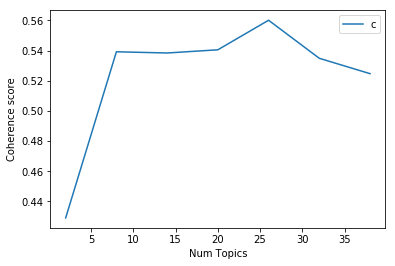

In [24]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4291
Num Topics = 8  has Coherence Value of 0.5392
Num Topics = 14  has Coherence Value of 0.5384
Num Topics = 20  has Coherence Value of 0.5405
Num Topics = 26  has Coherence Value of 0.5601
Num Topics = 32  has Coherence Value of 0.5349
Num Topics = 38  has Coherence Value of 0.5247


In [26]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(23,
  '0.044*"trump" + 0.013*"president" + 0.012*"democrat" + 0.010*"american" + '
  '0.009*"america" + 0.007*"vote" + 0.007*"obama" + 0.007*"patriot" + '
  '0.006*"call" + 0.006*"state"'),
 (11,
  '0.076*"day" + 0.031*"today" + 0.026*"year" + 0.025*"woman" + 0.022*"guy" + '
  '0.016*"man" + 0.015*"make" + 0.012*"couple" + 0.011*"week" + '
  '0.011*"remember"'),
 (10,
  '0.016*"la" + 0.015*"video" + 0.015*"step" + 0.014*"follower" + '
  '0.012*"length_dtype" + 0.012*"para" + 0.009*"object" + 0.008*"name_tweet" + '
  '0.007*"con" + 0.007*"search"'),
 (9,
  '0.013*"الله" + 0.012*"اللهم" + 0.010*"على" + 0.007*"_" + 0.006*"name_tweet" '
  '+ 0.005*"انا" + 0.005*"camgirl" + 0.004*"ان" + 0.004*"انت" + 0.004*"الى"'),
 (17,
  '0.059*"people" + 0.055*"love" + 0.025*"feel" + 0.018*"hate" + 0.017*"talk" '
  '+ 0.016*"life" + 0.015*"person" + 0.014*"girl" + 0.013*"stay" + '
  '0.013*"thing"'),
 (22,
  '0.027*"send" + 0.020*"play" + 0.019*"hot" + 0.017*"pay" + 0.013*"foot" + '
  '0.012*"today" + 

In [27]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                print(row)
                first_topic = int(topic_num)
            elif j == 1: # 2nd most dominant topic
                second_topic = int(topic_num)
            elif j == 2: # 3rd most dominant topic
                third_topic = int(topic_num)
                sent_topics_df = sent_topics_df.append(pd.Series([first_topic, second_topic, third_topic]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['First_Topic', 'Second_Topic', 'Third_Topic']

    # Add original text to the end of the output
    contents = pd.Series(list(texts.keys()))
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'First_Topic', 'Second_Topic', 'Third_Topic', 'Document_ID']


[(3, 0.133399442791708), (13, 0.0990225244368891), (8, 0.09595315672663741), (2, 0.09226991547433538), (19, 0.08858667422203337), (22, 0.0585068706615668), (5, 0.0456155262785097), (25, 0.03947679085800632), (20, 0.03702129668980498), (17, 0.029040940643150593), (1, 0.028427067101100253), (18, 0.025357699390848566), (10, 0.023516078764697555), (15, 0.02228833168059688), (11, 0.020446711054445867), (7, 0.019832837512395528), (16, 0.01921896397034519), (12, 0.017991216886244516), (21, 0.016149596260093504), (0, 0.014307975633942488), (23, 0.014307975633942488), (4, 0.013080228549841814), (14, 0.013080228549841814), (9, 0.011852481465741138), (6, 0.01062473438164046), (24, 0.01062473438164046)]
[(1, 0.18164428164428165), (23, 0.1752950752950753), (8, 0.0837606837606838), (17, 0.06471306471306472), (19, 0.04725274725274725), (11, 0.04407814407814408), (13, 0.034554334554334556), (0, 0.034025234025234025), (15, 0.03243793243793244), (16, 0.02926332926332927), (18, 0.02926332926332927), (3, 

[(23, 0.43114909781576444), (1, 0.06302339635672968), (11, 0.05628938962272295), (5, 0.04394371061037727), (15, 0.03945437278770611), (8, 0.030475697142363808), (4, 0.02991452991452991), (18, 0.028231028231028233), (16, 0.027108693775360442), (3, 0.022619355952689286), (25, 0.022058188724855394), (2, 0.020374687041353708), (0, 0.01869118535785202), (14, 0.01644651644651645), (22, 0.015885349218682555), (20, 0.01532418199084866), (10, 0.014763014763014766), (12, 0.014201847535180868), (19, 0.014201847535180868), (13, 0.012518345851679186), (17, 0.011957178623845292), (24, 0.010834844168177501), (9, 0.010273676940343607), (21, 0.010273676940343607), (7, 0.010273676940343606), (6, 0.009712509712509712)]
[(18, 0.3366747564278427), (4, 0.08427420773099784), (11, 0.06872779712285884), (23, 0.06461257078541027), (5, 0.05592487073968553), (0, 0.03809222327740845), (13, 0.03763497590658083), (2, 0.031233512714994183), (17, 0.022545812669269454), (25, 0.022088565298441835), (19, 0.02117407055678

[(7, 0.3819403666731912), (1, 0.09610491289880606), (3, 0.07744503164350496), (17, 0.04097344555359824), (4, 0.029098975663861174), (25, 0.028250799243165668), (22, 0.02655444640177466), (2, 0.025706269981079156), (19, 0.021465387877601633), (11, 0.020617211456906124), (18, 0.019769035036210622), (20, 0.01807268219481961), (14, 0.017224505774124106), (16, 0.017224505774124106), (8, 0.0163763293534286), (5, 0.015528152932733096), (15, 0.015528152932733092), (0, 0.014679976512037587), (6, 0.014679976512037587), (9, 0.014679976512037587), (10, 0.014679976512037587), (12, 0.014679976512037587), (13, 0.014679976512037587), (21, 0.014679976512037587), (23, 0.014679976512037587), (24, 0.014679976512037587)]
[(21, 0.4318619782810764), (24, 0.36643315423156275), (6, 0.021900292457321627), (9, 0.015711079371556826), (3, 0.01187966174703575), (17, 0.010700764016413882), (1, 0.010406039583758415), (2, 0.009816590718447482), (7, 0.009816590718447482), (10, 0.009816590718447482), (20, 0.008637692987

[(19, 0.2498825960364422), (25, 0.17906452521837138), (17, 0.1253404714943177), (23, 0.03559688175072791), (22, 0.03437588052972669), (18, 0.033765379919226075), (13, 0.03254437869822486), (15, 0.02643937259321875), (14, 0.02582887198271814), (5, 0.02216586831971448), (4, 0.021555367709213867), (3, 0.020334366488212647), (1, 0.01850286465671082), (7, 0.016060862214708375), (20, 0.016060862214708375), (6, 0.014839860993707153), (11, 0.014839860993707153), (12, 0.014839860993707153), (0, 0.014229360383206541), (2, 0.013618859772705931), (16, 0.013618859772705931), (8, 0.012397858551704711), (10, 0.011787357941204099), (24, 0.011176857330703489), (9, 0.010566356720202877), (21, 0.010566356720202877)]
[(15, 0.31562203228869895), (7, 0.2594491927825261), (17, 0.04278252611585945), (16, 0.03167141500474834), (1, 0.02920227920227921), (3, 0.028584995251661922), (11, 0.023646723646723652), (2, 0.019943019943019946), (12, 0.018708452041785378), (19, 0.0180911680911681), (13, 0.01747388414055081

[(18, 0.440772155601053), (0, 0.09898930811478343), (13, 0.055051834519515126), (5, 0.03942023333658314), (15, 0.03857528192128952), (17, 0.027590913522472452), (19, 0.027590913522472452), (1, 0.023788632153651165), (10, 0.021676253615417113), (16, 0.01998635078482987), (11, 0.019563875077183063), (23, 0.019141399369536252), (2, 0.017873972246595822), (20, 0.01745149653894901), (7, 0.016606545123655392), (12, 0.01576159370836177), (14, 0.013649215170127718), (8, 0.012381788047187288), (3, 0.011114360924246856), (22, 0.010269409508953237), (25, 0.010269409508953237), (21, 0.009846933801306426), (4, 0.009424458093659617), (6, 0.008157030970719185), (9, 0.007734555263072375), (24, 0.007312079555425563)]
[(0, 0.6275759005820357), (12, 0.03350637092968382), (4, 0.03180221278380787), (5, 0.031120549525457498), (16, 0.023963085312778562), (23, 0.023281422054428187), (7, 0.022940590425252996), (20, 0.02055476902102669), (15, 0.018509779245975567), (11, 0.01646478947092444), (14, 0.014419799695

[(12, 0.742724223736882), (10, 0.052850806015362975), (7, 0.018743914313534563), (25, 0.013821270150384072), (2, 0.011008330628583791), (5, 0.011008330628583791), (8, 0.011008330628583791), (13, 0.009601860867683651), (21, 0.009601860867683651), (18, 0.008898625987233582), (23, 0.008898625987233582), (22, 0.00819539110678351), (17, 0.007843773666558477), (19, 0.007492156226333441), (24, 0.007492156226333441), (6, 0.007140538786108406), (14, 0.007140538786108406), (1, 0.006788921345883371), (3, 0.006437303905658336), (4, 0.006437303905658336), (20, 0.006437303905658336), (0, 0.006085686465433299), (9, 0.006085686465433299), (11, 0.006085686465433299), (15, 0.006085686465433299), (16, 0.006085686465433299)]
[(14, 0.1536907536907537), (5, 0.11530691530691536), (11, 0.08298368298368301), (16, 0.056216006216006226), (19, 0.0536907536907537), (18, 0.0531857031857032), (17, 0.04965034965034965), (25, 0.04864024864024865), (22, 0.043589743589743594), (13, 0.04055944055944056), (20, 0.036519036

[(23, 0.3190767846638292), (5, 0.07346274957610992), (1, 0.0626665282535728), (20, 0.051870306931035684), (19, 0.04512266860444998), (4, 0.03927471538807571), (17, 0.03747534516765286), (25, 0.03477628983701858), (18, 0.032527077061490016), (8, 0.03027786428596145), (21, 0.028928336620644313), (2, 0.027578808955327175), (11, 0.02622928129001004), (13, 0.024879753624692896), (16, 0.019931485518530054), (10, 0.017682272743001493), (0, 0.01633274507768435), (3, 0.01633274507768435), (22, 0.0145333748572615), (24, 0.01408353230215579), (7, 0.013183847191944362), (14, 0.013183847191944362), (15, 0.01273400463683865), (6, 0.010484791861310083), (9, 0.008685421640887231), (12, 0.008685421640887231)]
[(11, 0.14369201548688731), (3, 0.11710132222952735), (20, 0.0753159471108189), (2, 0.0696179414128132), (12, 0.06107093286580466), (18, 0.03922857769011615), (19, 0.038278910073781876), (14, 0.03353057199211046), (5, 0.032580904375776175), (17, 0.03163123675944189), (23, 0.03163123675944189), (25

[(25, 0.21363564419119976), (17, 0.1817426400759734), (13, 0.07886198163975944), (11, 0.07063152896486231), (2, 0.04902659069325737), (16, 0.041310541310541314), (19, 0.03873852484963597), (12, 0.035137701804368475), (5, 0.02947926559037671), (23, 0.024849635960747078), (7, 0.02433523266856601), (18, 0.022277619499841726), (1, 0.021763216207660658), (8, 0.01867679645457424), (22, 0.018162393162393167), (10, 0.017133586578031025), (15, 0.01610477999366889), (14, 0.015590376701487819), (20, 0.015590376701487819), (3, 0.010960747071858188), (4, 0.009931940487496047), (0, 0.009417537195314978), (9, 0.009417537195314978), (6, 0.009417537195314976), (21, 0.008903133903133905), (24, 0.008903133903133905)]
[(21, 0.6398455101383972), (24, 0.09544755569860174), (6, 0.025712548725101026), (18, 0.017809247934770945), (20, 0.015484747702320922), (7, 0.014554947609340915), (8, 0.014554947609340915), (16, 0.012695347423380897), (9, 0.011300647283910883), (15, 0.011300647283910883), (19, 0.01130064728

[(17, 0.2564948802572565), (25, 0.19818904967419818), (11, 0.05902513328255903), (13, 0.05297452822205297), (22, 0.04252348311754252), (5, 0.04197342811204197), (3, 0.02987221799102988), (19, 0.026021832952526025), (18, 0.025471777947025476), (0, 0.023821612930523824), (14, 0.02327155792502328), (2, 0.022721502919522726), (8, 0.019971227892019973), (15, 0.019421172886519424), (4, 0.018871117881018876), (23, 0.018321062875518324), (1, 0.015570787848015575), (16, 0.015020732842515027), (12, 0.014470677837014475), (20, 0.013370567826013374), (7, 0.012270457815012275), (9, 0.010620292798510622), (6, 0.010070237793010074), (21, 0.010070237793010074), (24, 0.010070237793010072), (10, 0.009520182787509521)]
[(17, 0.41574032903512664), (13, 0.15305567906723977), (25, 0.03552196037745169), (19, 0.03359517810384862), (11, 0.031026135072377843), (3, 0.029741613556642454), (2, 0.026530309767303986), (0, 0.019465441430759352), (5, 0.019465441430759352), (1, 0.018823180672891654), (4, 0.018823180672

[(8, 0.45224653022818173), (4, 0.15866854857680546), (16, 0.03073786560025092), (18, 0.02767976162471576), (11, 0.026660393632870705), (3, 0.023092605661413006), (13, 0.022073237669567952), (14, 0.021053869677722895), (23, 0.020544185681800366), (10, 0.020034501685877837), (17, 0.020034501685877837), (0, 0.017486081706265196), (7, 0.017486081706265196), (12, 0.017486081706265196), (2, 0.012898925742962445), (21, 0.012898925742962445), (1, 0.01136987375519486), (5, 0.01136987375519486), (15, 0.010860189759272334), (25, 0.010860189759272334), (22, 0.009840821767427276), (9, 0.009331137771504747), (6, 0.008821453775582218), (19, 0.008821453775582218), (20, 0.008821453775582218), (24, 0.008821453775582218)]
[(0, 0.3638687997662356), (19, 0.09701219957630214), (15, 0.09131419387829642), (18, 0.08039301629045217), (17, 0.07754401344144933), (11, 0.02673679596756518), (8, 0.02626196215939805), (22, 0.024837460734896625), (2, 0.02293812550222806), (13, 0.01913945503689093), (14, 0.018189787420

In [29]:
os.chdir("..")
df_dominant_topic.to_csv("DominantTopics.csv", sep=',')